In [13]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from numpy import random
from mpmath import mp
import time 
import copy 
import csv

In [ ]:

def load_csv_with_counter(file_name):
    row_counter = 0
    rowwise_lists = []

    # Open and read the CSV file
    with open(file_name, mode='r') as file:
        reader = csv.reader(file)
        headers = next(reader)  # Skip header row

        # Iterate through each row in the CSV file
        for row in reader:
            row_as_int = [int(value) for value in row]  # Convert each value to integer
            rowwise_lists.append(row_as_int)
            row_counter += 1  # Increment the counter
    return rowwise_lists

file_name = "C:\\Intern\\Gittin\'s plots\\All codes directory\\Fig 3 B,C (Mono HR)\\jobsize_data.csv"  # Replace with the actual file name
rowwise_lists = load_csv_with_counter(file_name)


In [14]:
def calculate_v_values(Q_values_action1, Q_values_action2):
    V_values = np.zeros((100,9))
    for i in range(100):
        for j in range(9):
            V_values[i][j] = max(Q_values_action1[i][j],Q_values_action2[i][j])  # Use keepdims=True to maintain the 2D shape
    return V_values

V_true = np.zeros((100,9))
V_true[1,:] = [ 2.88866783e+01,  3.15085928e+01,  3.40536870e+01,  3.57302799e+01,
   3.86458610e+01,  4.02700595e+01,  4.33413655e+01,  4.58000668e+01,
   4.77588016e+01]
V_true[2,:] =  [ 4.10888854e+01 , 4.65526320e+01,  5.26920938e+01,  5.59839147e+01,
   6.45651019e+01,  6.85675634e+01,  7.75534687e+01,  8.56410058e+01,
   9.25763321e+01]
V_true[3,:] =  [ 5.08628628e+01,  5.63930518e+01,  5.98191169e+01,  6.61043434e+01,
   7.16273587e+01,  7.58738044e+01,  8.24998123e+01,  8.61913750e+01,
   8.50192653e+01]
V_true[4,:] =  [ 6.24605652e+01,  6.27808790e+01,  6.82740106e+01,  7.22510249e+01,
   7.60514963e+01,  7.29368165e+01,  6.19245576e+01,  4.28895914e+01,
   1.27635876e+01]
V_true[5,:] =  [ 6.81366238e+01,  6.80016985e+01,  6.64720862e+01,  6.06085033e+01,
   4.33396239e+01,  3.39154748e+01,  1.60047605e+01,  5.21846082e+00,
   8.90324633e-01]
V_true[6,:] = [ 6.19898757e+01,  5.50271944e+01,  4.17116023e+01 , 2.65621589e+01,
   1.38618104e+01,  5.76521983e+00,  1.18218252e+00,  2.99576000e-01,
   0.00000000e+00]
V_true[7,:] =  [ 3.52320491e+01,  2.41356914e+01,  1.21776708e+01,  5.48761699e+00,
   2.23389373e+00,  8.89787830e-01,  0.00000000e+00,  0.00000000e+00,
   0.00000000e+00]
V_true[8,:] = [ 9.26027985e+00,  5.04402188e+00,  4.08399120e+00,  5.92930470e-01,
   1.18520760e+00,  0.00000000e+00,  2.98702000e-01,  0.00000000e+00,
   0.00000000e+00]
V_true[9,:] =  [ 1.76669278e+00,  1.77985116e+00,  2.95460000e-01,  0.00000000e+00,
   0.00000000e+00,  0.00000000e+00 , 0.00000000e+00  ,0.00000000e+00,
   0.00000000e+00]

def bellman_relative_error(V_approx, V_true):
    nonzero_indices = V_true != 0
    if np.any(nonzero_indices):
        #relative_errors = np.abs((V_approx[nonzero_indices] - V_true[nonzero_indices]) / V_true[nonzero_indices])
        relative_errors = np.abs((V_approx[nonzero_indices] - V_true[nonzero_indices]))
        return np.mean(relative_errors)
    else:
        return np.nan

In [10]:
def get_prob(step,p1,lamda):
    pi = [0]*step
    for i in range(1,step):
        pi[i]=(1-(1-p1)*((lamda)**(i)))
    mul = pi[step-1]
    return mul 

class envir():
    def __init__(self):
        self.phi = 9
        self.lamda = 0.8 
        self.p1=[]
        for i in range(9):
            self.p1.append(0.1*(i+1))
    def step(self,s,task):
            next_state = copy.copy(s)
            if s[task] == 0:
                next_state[task] = 0
            else:
                #print(s,task,get_prob(s[task],self.p1[task],self.lamda))
                next_state[task] = random.choice([0,s[task]+1],1,p=[get_prob(s[task],self.p1[task],self.lamda),1-get_prob(s[task],self.p1[task],self.lamda)])
            if s[task]!=0 and next_state[task] == 0:
                reward = 1
            elif s[task]==0:
                reward = -10000
            else:
                reward = 0
            return next_state,reward
            

In [11]:
class Agent():
    def __init__(self,alpha,T,gamma):
        self.Q_values = np.zeros((100,2,100,9))
        self.phi = 9
        self.alpha = alpha
        self.T = T
        self.gamma = gamma
    def activate_task(self,s):
        num = []
        summ = 0
        prob = []
        for i in range(9):
            num.append(mp.exp((self.Q_values[s[i]][0][s[i]][i])/self.T))
            summ = summ + mp.exp((self.Q_values[s[i]][0][s[i]][i])/self.T)
        for i in range(9):
            prob.append(num[i]/summ)
        task = random.choice(9,1,p=prob)
        return task[0]

    def activate_task_eps_greedy(self,s,epsilon):
        r = random.random()
        if r < epsilon:
            action = np.random.choice(9)
        else:
            gre = [0]*len(s)
            for i in range(len(s)):
                gre[i] = self.Q_values[s[i]][0][s[i]][i]
            action = np.argmax(gre)
        return action
    
    def check_best_action(self,state):
        inds = np.argmax(state)
        all_inds = []
        for i in range(len(state)):
            if state[inds] == state[i]:
                all_inds.append(i)
        return all_inds

    def act_greedy(self,s,restart_prob,task):
        return max((self.Q_values[s[task]][0][restart_prob][task]),(self.Q_values[s[task]][1][restart_prob][task]))
    
    def update(self,s,task,next_state,reward):
        for k in range(10):
            self.Q_values[s[task]][0][k][task] = (1-self.alpha)*(self.Q_values[s[task]][0][k][task]) + self.alpha*(reward+self.gamma*(self.act_greedy(next_state,k,task)))
            self.Q_values[k][1][s[task]][task] = (1-self.alpha)*(self.Q_values[k][1][s[task]][task]) + self.alpha*(reward+self.gamma*(self.act_greedy(next_state,s[task],task)))

  0%|          | 0/2500 [00:00<?, ?it/s]C:\Users\Harshit\AppData\Local\Temp\ipykernel_14272\2691367578.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_state[task] = random.choice([0,s[task]+1],1,p=[get_prob(s[task],self.p1[task],self.lamda),1-get_prob(s[task],self.p1[task],self.lamda)])
100%|██████████| 2500/2500 [04:13<00:00,  9.86it/s]


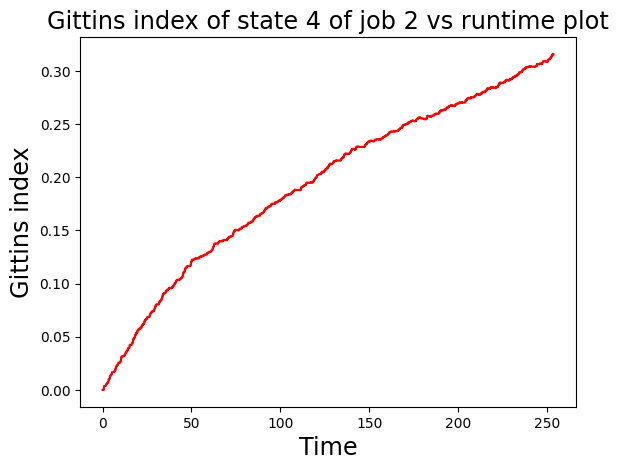

[[-1.41011031e+05 -2.61480968e+05 -3.59847755e+05 -4.10618283e+05
  -4.66302543e+05 -5.60359506e+05 -5.83310898e+05 -6.31201335e+05
  -7.09561274e+05]
 [ 2.27681053e+01  2.54601136e+01  2.68095946e+01  2.97459177e+01
   3.20201929e+01  3.45487340e+01  3.69909896e+01  3.93345559e+01
   4.23839253e+01]
 [ 3.35170717e+01  3.98657058e+01  4.38827349e+01  5.11575072e+01
   5.74270268e+01  6.44934894e+01  7.09851835e+01  7.68239072e+01
   8.45351130e+01]
 [ 3.74089889e+01  4.21451345e+01  4.25313582e+01  4.43555075e+01
   4.37691541e+01  4.24157807e+01  3.61610613e+01  2.91230283e+01
   1.68542340e+01]
 [ 3.56839469e+01  3.15786846e+01  3.00652060e+01  2.59733354e+01
   1.96419327e+01  1.31390528e+01  9.22828240e+00  5.34399540e+00
   1.35625418e+00]
 [ 2.47720069e+01  2.01034068e+01  1.61375723e+01  9.31942132e+00
   5.93217749e+00  4.09232564e+00  1.55676452e+00  1.05324395e+00
   0.00000000e+00]
 [ 1.35966504e+01  7.02288232e+00  4.98582958e+00  1.96780538e+00
   1.86206305e+00  4.3047616

In [12]:
from tqdm import tqdm
class pull():
        start_time = time.time()
        env = envir()
        hist01 = []
        t = []
        agent = Agent(alpha=0.3,T=1000,gamma=0.99)
        episode = 2500
        agent.alpha = 0.1
        cumm_rew = []
        BRE = []
        plt_wrong_actions = []
        cumm_wrong_steps = []
        agent.gamma = 0.99
        agent.T = 750000
        Tmax = 750000
        Tmin = 0.25
        s = np.array([1,1,1,1,1,1,1,1,1])
        phi = 3
        eps = 0.2
        for ep_no in tqdm(range(episode)):
            s = np.array([1,1,1,1,1,1,1,1,1])
            episode_rew = 0
            while (s[0]!=0 or s[1]!=0 or s[2]!=0 or s[3]!=0 or s[4]!=0 or s[5]!=0 or s[6]!=0 or s[7]!=0 or s[8]!=0):
                #print(s)
                task = agent.activate_task(s)
                if len(cumm_rew)==0:
                    cumm_rew.append(episode_rew)
                else:
                    cumm_rew.append(cumm_rew[-1]+episode_rew)
                task_eps = agent.activate_task_eps_greedy(s,eps)
                task = task_eps
                task_opt = agent.check_best_action(s)
                if task_eps not in task_opt:
                    cumm_wrong_steps.append(1)
                else:
                    cumm_wrong_steps.append(0)
                plt_wrong_actions.append(np.mean(cumm_wrong_steps)*100)
                Q0 = np.zeros((100,9))
                M = np.zeros((100,9))
                for i in range(100):
                    for j in range(9):
                        Q0[i][j] = agent.Q_values[i][0][i][j]
                        M[i][j] = agent.Q_values[i][1][i][j]
                V_values = calculate_v_values(Q0,M)
                BRE.append(bellman_relative_error(V_values,V_true))

                #print(task)
                current_time = time.time()-start_time
                next_state,reward = env.step(s,task)
                agent.update(s,task,next_state,reward)
                t.append(current_time)
                if((ep_no%100)==0):
                    agent.alpha = agent.alpha-0.000002
                s = copy.copy(next_state)
                hist01.append(0.01*agent.Q_values[4][0][4][1])
        plt.title('Gittins index of state 4 of job 2 vs runtime plot',fontsize='xx-large')
        plt.xlabel('Time', fontsize = 'xx-large')
        plt.ylabel('Gittins index',fontsize = 'xx-large')
        plt.plot(t,hist01,'-',c='red')
        plt.show()
        filename = 'C:\\Intern\\percent_wrong_restart_monoHR.csv'
        V_values = calculate_v_values(Q0,M)
        print(V_values)
        # Writing to CSV file
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['percent_wrong'])  # Writing the header
            for value in plt_wrong_actions:
                writer.writerow([value])  # Writing each value in a new row

        filename = 'C:\\Intern\\BRE_restart_monoHR.csv'

        # Writing to CSV file
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['BRE'])  # Writing the header
            for value in BRE:
                writer.writerow([value])  # Writing each value in a new row

        filename = 'C:\\Intern\\cumm_rew_restart_monoHR.csv'

        # Writing to CSV file
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['cumm_rew'])  # Writing the header
            for value in cumm_rew:
                writer.writerow([value])  # Writing each value in a new row     
